# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

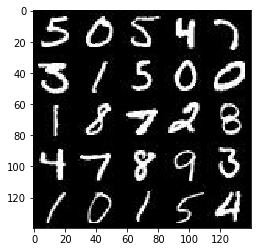

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

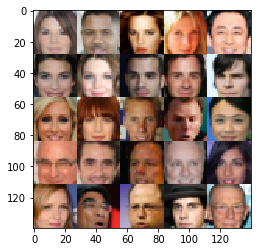

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, shape=(None, z_dim), name='input_z')
    lr = tf.placeholder(tf.float32, name='lr')
    # Looks like when it named it learning_rate, it confuses between tensor and value at train process
    # So I decided to name it lr
    
    return input_real, input_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.1
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Use 4 layer network
        
        # Input layer is 28x28x3
        conv1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='SAME', activation=None)
        conv1 = tf.maximum(alpha * conv1, conv1)
        # 14x14x64
        
        # Layer 2
        conv2 = tf.layers.conv2d(conv1, 128, 5, strides=2, padding='SAME', activation=None)
        conv2 = tf.layers.batch_normalization(conv2, training=True)
        conv2 = tf.maximum(alpha * conv2, conv2)
        # 7x7x128
        
        # Layer 3
        conv3 = tf.layers.conv2d(conv2, 256, 5, strides=1, padding='SAME', activation=None)
        conv3 = tf.layers.batch_normalization(conv3, training=True)
        conv3 = tf.maximum(alpha * conv3, conv3)
        # 7x7x256
        
        # Layer 4
        conv4 = tf.layers.conv2d(conv3, 512, 5, strides=1, padding='SAME', activation=None)
        conv4 = tf.layers.batch_normalization(conv4, training=True)
        conv4 = tf.maximum(alpha * conv4,conv4)
        # 7x7x512

        # Flatten it
        flat = tf.reshape(conv4, (-1, 7*7*512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.1
    
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        g1 = tf.layers.dense(z, 7*7*512)
        g1 = tf.reshape(g1, (-1, 7, 7, 512))
        g1 = tf.layers.batch_normalization(g1, training=is_train)
        g1 = tf.maximum(alpha * g1, g1)
        # 7x7x512
        
        # Layer 2
        g2 = tf.layers.conv2d_transpose(g1, 256, 5, strides=1, padding='SAME', activation=None)
        g2 = tf.layers.batch_normalization(g2, training=is_train)
        g2 = tf.maximum(alpha * g2, g2)
        # 7x7x256
        
        # Layer 3
        g3 = tf.layers.conv2d_transpose(g2, 128, 5, strides=2, padding='SAME', activation=None)
        g3 = tf.layers.batch_normalization(g3, training=is_train)
        g3 = tf.maximum(alpha * g3, g3)   
        # 14x14x128
        
        # Layer 4
        g4 = tf.layers.conv2d_transpose(g3, 64, 5, strides=2, padding='SAME', activation=None)
        g4 = tf.layers.batch_normalization(g4, training=is_train)
        g4 = tf.maximum(alpha * g4, g4)   
        # 28x28x64
        
        logits = tf.layers.conv2d_transpose(g4, out_channel_dim, 3, strides=1, padding='SAME', activation=None)
        # shape = 28x28x3
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    smooth = 0.1
    
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                labels=tf.ones_like(d_model_real)*(1-smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    steps = 0
    
    print_every = 10
    show_every = 100
    
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_images = batch_images * 2
                steps += 1
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, 
                                               input_z: batch_z, 
                                               lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images,
                                               input_z: batch_z, 
                                               lr: learning_rate})
                if steps == 1:
                    print('initial output:')
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
                    
                if steps % print_every == 0:
                    # At the end of every 10 epochs, get the losses and print them out
                    train_loss_d = d_loss.eval({input_real: batch_images,
                                                input_z: batch_z,  
                                                lr: learning_rate})
                    train_loss_g = g_loss.eval({input_real: batch_images,
                                                input_z: batch_z, 
                                                lr: learning_rate})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

initial output:


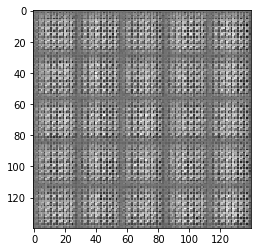

Epoch 1/2... Discriminator Loss: 1.1563... Generator Loss: 8.9535
Epoch 1/2... Discriminator Loss: 5.1793... Generator Loss: 0.2437
Epoch 1/2... Discriminator Loss: 1.0521... Generator Loss: 3.0855
Epoch 1/2... Discriminator Loss: 1.4613... Generator Loss: 2.1656
Epoch 1/2... Discriminator Loss: 0.4612... Generator Loss: 6.5076
Epoch 1/2... Discriminator Loss: 0.6177... Generator Loss: 17.7677
Epoch 1/2... Discriminator Loss: 0.4980... Generator Loss: 4.7970
Epoch 1/2... Discriminator Loss: 0.4025... Generator Loss: 4.4207
Epoch 1/2... Discriminator Loss: 6.6242... Generator Loss: 16.7389
Epoch 1/2... Discriminator Loss: 3.0361... Generator Loss: 0.2386


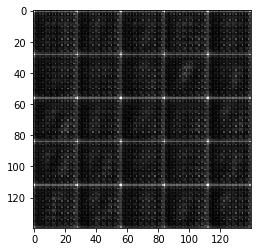

Epoch 1/2... Discriminator Loss: 1.1246... Generator Loss: 1.9306
Epoch 1/2... Discriminator Loss: 1.2418... Generator Loss: 3.9955
Epoch 1/2... Discriminator Loss: 0.9427... Generator Loss: 2.0132
Epoch 1/2... Discriminator Loss: 1.0647... Generator Loss: 1.0285
Epoch 1/2... Discriminator Loss: 2.5219... Generator Loss: 0.2280
Epoch 1/2... Discriminator Loss: 1.1285... Generator Loss: 0.8835
Epoch 1/2... Discriminator Loss: 1.2996... Generator Loss: 1.5086
Epoch 1/2... Discriminator Loss: 1.7620... Generator Loss: 4.0636
Epoch 1/2... Discriminator Loss: 1.7494... Generator Loss: 2.2126
Epoch 1/2... Discriminator Loss: 1.2987... Generator Loss: 2.0660


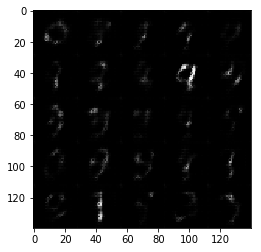

Epoch 1/2... Discriminator Loss: 1.3081... Generator Loss: 0.7264
Epoch 1/2... Discriminator Loss: 1.5562... Generator Loss: 0.5695
Epoch 1/2... Discriminator Loss: 1.4796... Generator Loss: 2.1023
Epoch 1/2... Discriminator Loss: 1.1443... Generator Loss: 1.6146
Epoch 1/2... Discriminator Loss: 1.2249... Generator Loss: 1.3233
Epoch 1/2... Discriminator Loss: 1.1060... Generator Loss: 1.1835
Epoch 1/2... Discriminator Loss: 1.2631... Generator Loss: 0.8556
Epoch 1/2... Discriminator Loss: 1.2909... Generator Loss: 2.1561
Epoch 1/2... Discriminator Loss: 1.4986... Generator Loss: 0.5244
Epoch 1/2... Discriminator Loss: 1.3751... Generator Loss: 2.0450


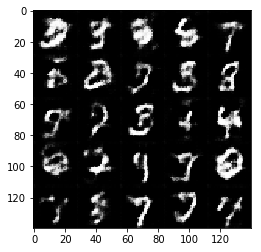

Epoch 1/2... Discriminator Loss: 1.5108... Generator Loss: 1.7821
Epoch 1/2... Discriminator Loss: 1.4023... Generator Loss: 0.6665
Epoch 1/2... Discriminator Loss: 1.2448... Generator Loss: 0.8761
Epoch 1/2... Discriminator Loss: 1.2594... Generator Loss: 1.3881
Epoch 1/2... Discriminator Loss: 1.3039... Generator Loss: 0.7149
Epoch 1/2... Discriminator Loss: 1.2098... Generator Loss: 1.2486
Epoch 1/2... Discriminator Loss: 1.7434... Generator Loss: 0.3925
Epoch 1/2... Discriminator Loss: 1.1389... Generator Loss: 1.1517
Epoch 1/2... Discriminator Loss: 1.5900... Generator Loss: 0.4379
Epoch 1/2... Discriminator Loss: 1.1433... Generator Loss: 0.9132


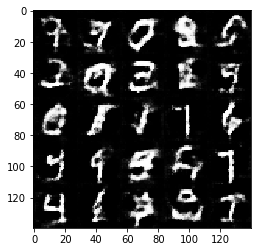

Epoch 1/2... Discriminator Loss: 1.2206... Generator Loss: 1.1545
Epoch 1/2... Discriminator Loss: 1.6111... Generator Loss: 0.4207
Epoch 1/2... Discriminator Loss: 1.4915... Generator Loss: 0.4985
Epoch 1/2... Discriminator Loss: 1.4419... Generator Loss: 1.3905
Epoch 1/2... Discriminator Loss: 1.4310... Generator Loss: 2.2411
Epoch 1/2... Discriminator Loss: 1.3907... Generator Loss: 0.5363
Epoch 1/2... Discriminator Loss: 1.3959... Generator Loss: 2.0086
Epoch 1/2... Discriminator Loss: 1.4576... Generator Loss: 1.8828
Epoch 1/2... Discriminator Loss: 1.5396... Generator Loss: 0.4904
Epoch 1/2... Discriminator Loss: 1.3664... Generator Loss: 1.4891


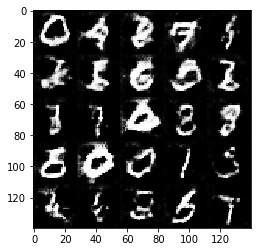

Epoch 1/2... Discriminator Loss: 1.7044... Generator Loss: 0.3921
Epoch 1/2... Discriminator Loss: 1.3103... Generator Loss: 0.8267
Epoch 1/2... Discriminator Loss: 1.1193... Generator Loss: 0.8546
Epoch 1/2... Discriminator Loss: 1.6455... Generator Loss: 2.1994
Epoch 1/2... Discriminator Loss: 1.1904... Generator Loss: 0.8464
Epoch 1/2... Discriminator Loss: 1.4274... Generator Loss: 0.5001
Epoch 1/2... Discriminator Loss: 1.4365... Generator Loss: 0.6059
Epoch 1/2... Discriminator Loss: 1.3489... Generator Loss: 0.6301
Epoch 1/2... Discriminator Loss: 1.6294... Generator Loss: 0.4740
Epoch 1/2... Discriminator Loss: 1.2629... Generator Loss: 0.9659


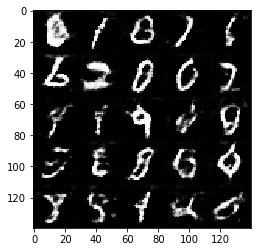

Epoch 1/2... Discriminator Loss: 1.2576... Generator Loss: 2.2282
Epoch 1/2... Discriminator Loss: 1.4276... Generator Loss: 1.6338
Epoch 1/2... Discriminator Loss: 1.1925... Generator Loss: 0.8308
Epoch 1/2... Discriminator Loss: 1.7773... Generator Loss: 0.4230
Epoch 1/2... Discriminator Loss: 1.5546... Generator Loss: 1.7845
Epoch 1/2... Discriminator Loss: 1.1432... Generator Loss: 1.3185
Epoch 1/2... Discriminator Loss: 1.7701... Generator Loss: 0.3855
Epoch 1/2... Discriminator Loss: 1.1221... Generator Loss: 0.8783
Epoch 1/2... Discriminator Loss: 1.0995... Generator Loss: 1.2176
Epoch 1/2... Discriminator Loss: 1.5551... Generator Loss: 0.4598


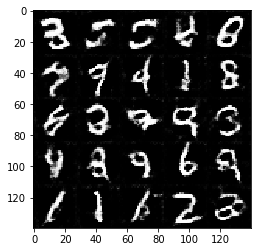

Epoch 1/2... Discriminator Loss: 1.2001... Generator Loss: 1.6908
Epoch 1/2... Discriminator Loss: 1.2957... Generator Loss: 1.6779
Epoch 1/2... Discriminator Loss: 1.2580... Generator Loss: 0.6422
Epoch 1/2... Discriminator Loss: 1.4803... Generator Loss: 0.5826
Epoch 1/2... Discriminator Loss: 1.3139... Generator Loss: 0.8253
Epoch 1/2... Discriminator Loss: 1.4486... Generator Loss: 1.5692
Epoch 1/2... Discriminator Loss: 1.3679... Generator Loss: 0.5956
Epoch 1/2... Discriminator Loss: 1.6344... Generator Loss: 0.4319
Epoch 1/2... Discriminator Loss: 1.3220... Generator Loss: 1.8786
Epoch 1/2... Discriminator Loss: 1.2289... Generator Loss: 0.9185


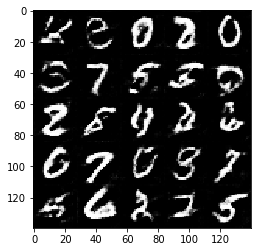

Epoch 1/2... Discriminator Loss: 1.7641... Generator Loss: 0.3706
Epoch 1/2... Discriminator Loss: 1.6282... Generator Loss: 0.4316
Epoch 1/2... Discriminator Loss: 1.4883... Generator Loss: 0.5186
Epoch 1/2... Discriminator Loss: 1.6171... Generator Loss: 0.4537
Epoch 1/2... Discriminator Loss: 1.2492... Generator Loss: 0.8284
Epoch 1/2... Discriminator Loss: 1.4406... Generator Loss: 0.5866
Epoch 1/2... Discriminator Loss: 1.1172... Generator Loss: 1.0217
Epoch 1/2... Discriminator Loss: 1.1938... Generator Loss: 0.8134
Epoch 1/2... Discriminator Loss: 1.3318... Generator Loss: 1.0671
Epoch 1/2... Discriminator Loss: 1.3266... Generator Loss: 2.1731


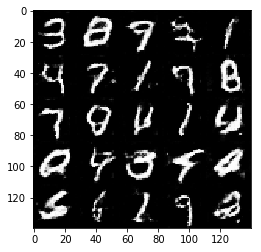

Epoch 1/2... Discriminator Loss: 1.3338... Generator Loss: 0.6048
Epoch 1/2... Discriminator Loss: 1.2799... Generator Loss: 1.3843
Epoch 1/2... Discriminator Loss: 1.3495... Generator Loss: 2.0988
Epoch 2/2... Discriminator Loss: 1.1387... Generator Loss: 0.8542
Epoch 2/2... Discriminator Loss: 1.1833... Generator Loss: 0.8217
Epoch 2/2... Discriminator Loss: 1.9416... Generator Loss: 0.3071
Epoch 2/2... Discriminator Loss: 1.4994... Generator Loss: 0.5586
Epoch 2/2... Discriminator Loss: 1.0478... Generator Loss: 1.0190
Epoch 2/2... Discriminator Loss: 1.0382... Generator Loss: 1.9059
Epoch 2/2... Discriminator Loss: 1.6352... Generator Loss: 0.4660


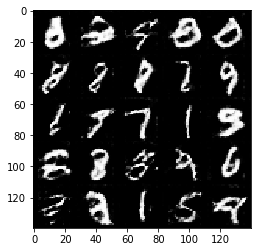

Epoch 2/2... Discriminator Loss: 1.2550... Generator Loss: 0.7287
Epoch 2/2... Discriminator Loss: 1.2509... Generator Loss: 1.2117
Epoch 2/2... Discriminator Loss: 1.7301... Generator Loss: 0.4136
Epoch 2/2... Discriminator Loss: 1.4269... Generator Loss: 0.6249
Epoch 2/2... Discriminator Loss: 1.3082... Generator Loss: 0.7770
Epoch 2/2... Discriminator Loss: 1.4191... Generator Loss: 2.2764
Epoch 2/2... Discriminator Loss: 1.5766... Generator Loss: 0.4164
Epoch 2/2... Discriminator Loss: 2.0335... Generator Loss: 2.4621
Epoch 2/2... Discriminator Loss: 0.9927... Generator Loss: 1.2226
Epoch 2/2... Discriminator Loss: 0.9717... Generator Loss: 1.5268


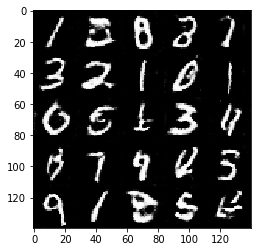

Epoch 2/2... Discriminator Loss: 1.4423... Generator Loss: 1.3698
Epoch 2/2... Discriminator Loss: 1.2880... Generator Loss: 1.8692
Epoch 2/2... Discriminator Loss: 1.6051... Generator Loss: 0.4009
Epoch 2/2... Discriminator Loss: 1.1822... Generator Loss: 1.0040
Epoch 2/2... Discriminator Loss: 1.6133... Generator Loss: 0.4634
Epoch 2/2... Discriminator Loss: 1.5932... Generator Loss: 0.4847
Epoch 2/2... Discriminator Loss: 1.2526... Generator Loss: 0.8932
Epoch 2/2... Discriminator Loss: 1.0671... Generator Loss: 1.5938
Epoch 2/2... Discriminator Loss: 1.3152... Generator Loss: 1.9524
Epoch 2/2... Discriminator Loss: 1.3055... Generator Loss: 0.6536


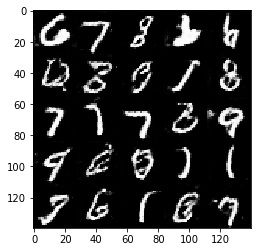

Epoch 2/2... Discriminator Loss: 1.2919... Generator Loss: 0.6982
Epoch 2/2... Discriminator Loss: 1.0162... Generator Loss: 1.1340
Epoch 2/2... Discriminator Loss: 1.4567... Generator Loss: 0.5647
Epoch 2/2... Discriminator Loss: 1.0990... Generator Loss: 1.0804
Epoch 2/2... Discriminator Loss: 1.5544... Generator Loss: 0.5192
Epoch 2/2... Discriminator Loss: 1.4410... Generator Loss: 0.7301
Epoch 2/2... Discriminator Loss: 1.1959... Generator Loss: 1.6427
Epoch 2/2... Discriminator Loss: 2.3157... Generator Loss: 0.2345
Epoch 2/2... Discriminator Loss: 1.1997... Generator Loss: 1.3138
Epoch 2/2... Discriminator Loss: 1.5081... Generator Loss: 1.8748


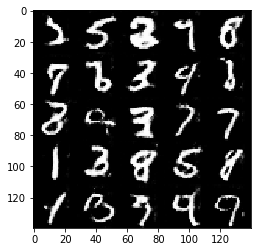

Epoch 2/2... Discriminator Loss: 2.1045... Generator Loss: 0.3046
Epoch 2/2... Discriminator Loss: 1.1684... Generator Loss: 1.8077
Epoch 2/2... Discriminator Loss: 1.3853... Generator Loss: 0.6841
Epoch 2/2... Discriminator Loss: 1.0621... Generator Loss: 0.9887
Epoch 2/2... Discriminator Loss: 1.3523... Generator Loss: 2.2155
Epoch 2/2... Discriminator Loss: 1.0393... Generator Loss: 1.1481
Epoch 2/2... Discriminator Loss: 1.1421... Generator Loss: 0.9646
Epoch 2/2... Discriminator Loss: 1.2704... Generator Loss: 0.9016
Epoch 2/2... Discriminator Loss: 1.3180... Generator Loss: 1.8143
Epoch 2/2... Discriminator Loss: 1.0080... Generator Loss: 0.9272


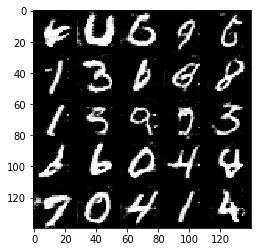

Epoch 2/2... Discriminator Loss: 1.4856... Generator Loss: 0.5172
Epoch 2/2... Discriminator Loss: 1.4609... Generator Loss: 0.5249
Epoch 2/2... Discriminator Loss: 2.6852... Generator Loss: 0.1606
Epoch 2/2... Discriminator Loss: 1.5476... Generator Loss: 0.6915
Epoch 2/2... Discriminator Loss: 1.1559... Generator Loss: 0.9346
Epoch 2/2... Discriminator Loss: 1.0973... Generator Loss: 1.3678
Epoch 2/2... Discriminator Loss: 1.2873... Generator Loss: 0.7649
Epoch 2/2... Discriminator Loss: 1.0957... Generator Loss: 2.0142
Epoch 2/2... Discriminator Loss: 1.4440... Generator Loss: 0.6880
Epoch 2/2... Discriminator Loss: 1.3175... Generator Loss: 1.3716


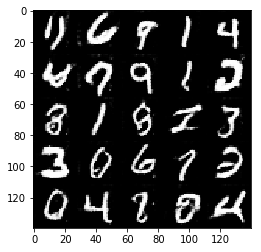

Epoch 2/2... Discriminator Loss: 1.9516... Generator Loss: 0.3917
Epoch 2/2... Discriminator Loss: 1.4785... Generator Loss: 0.5660
Epoch 2/2... Discriminator Loss: 1.5025... Generator Loss: 0.4637
Epoch 2/2... Discriminator Loss: 1.4293... Generator Loss: 0.7393
Epoch 2/2... Discriminator Loss: 1.3288... Generator Loss: 0.7263
Epoch 2/2... Discriminator Loss: 1.1848... Generator Loss: 0.8694
Epoch 2/2... Discriminator Loss: 1.1662... Generator Loss: 0.8853
Epoch 2/2... Discriminator Loss: 1.2071... Generator Loss: 0.8263
Epoch 2/2... Discriminator Loss: 1.1799... Generator Loss: 1.6886
Epoch 2/2... Discriminator Loss: 1.2798... Generator Loss: 0.8766


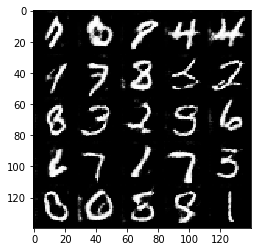

Epoch 2/2... Discriminator Loss: 1.0865... Generator Loss: 0.8392
Epoch 2/2... Discriminator Loss: 1.0493... Generator Loss: 1.0764
Epoch 2/2... Discriminator Loss: 0.9985... Generator Loss: 1.3029
Epoch 2/2... Discriminator Loss: 1.1626... Generator Loss: 1.1040
Epoch 2/2... Discriminator Loss: 1.1419... Generator Loss: 1.6239
Epoch 2/2... Discriminator Loss: 1.3487... Generator Loss: 1.6955
Epoch 2/2... Discriminator Loss: 1.6392... Generator Loss: 0.3972
Epoch 2/2... Discriminator Loss: 1.2672... Generator Loss: 0.6355
Epoch 2/2... Discriminator Loss: 1.3858... Generator Loss: 0.7403
Epoch 2/2... Discriminator Loss: 1.3984... Generator Loss: 2.0379


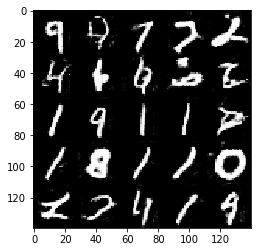

Epoch 2/2... Discriminator Loss: 1.1677... Generator Loss: 1.3169
Epoch 2/2... Discriminator Loss: 0.9688... Generator Loss: 1.2414
Epoch 2/2... Discriminator Loss: 1.4323... Generator Loss: 0.5292
Epoch 2/2... Discriminator Loss: 1.2217... Generator Loss: 1.3116
Epoch 2/2... Discriminator Loss: 1.0278... Generator Loss: 1.8081
Epoch 2/2... Discriminator Loss: 1.4718... Generator Loss: 2.8123
Epoch 2/2... Discriminator Loss: 1.0331... Generator Loss: 0.9286
Epoch 2/2... Discriminator Loss: 1.3024... Generator Loss: 2.0021
Epoch 2/2... Discriminator Loss: 1.4355... Generator Loss: 0.5884
Epoch 2/2... Discriminator Loss: 0.9743... Generator Loss: 1.5836


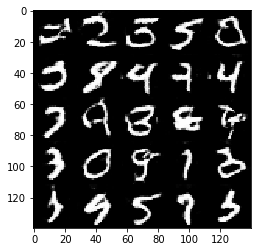

Epoch 2/2... Discriminator Loss: 1.0413... Generator Loss: 0.9666
Epoch 2/2... Discriminator Loss: 1.3971... Generator Loss: 0.6729
Epoch 2/2... Discriminator Loss: 1.5399... Generator Loss: 0.5129
Epoch 2/2... Discriminator Loss: 1.1632... Generator Loss: 1.2316
Epoch 2/2... Discriminator Loss: 1.7240... Generator Loss: 0.3921
Epoch 2/2... Discriminator Loss: 0.8940... Generator Loss: 1.2743
Epoch 2/2... Discriminator Loss: 1.1746... Generator Loss: 1.1458


In [14]:
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

initial output:


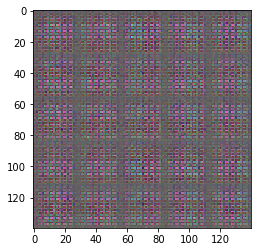

Epoch 1/1... Discriminator Loss: 2.0052... Generator Loss: 31.5667
Epoch 1/1... Discriminator Loss: 1.0919... Generator Loss: 13.7919
Epoch 1/1... Discriminator Loss: 3.0601... Generator Loss: 21.4325
Epoch 1/1... Discriminator Loss: 1.5400... Generator Loss: 6.3014
Epoch 1/1... Discriminator Loss: 0.8517... Generator Loss: 1.4824
Epoch 1/1... Discriminator Loss: 1.7773... Generator Loss: 3.5280
Epoch 1/1... Discriminator Loss: 0.9303... Generator Loss: 1.3281
Epoch 1/1... Discriminator Loss: 2.4662... Generator Loss: 0.2028
Epoch 1/1... Discriminator Loss: 1.5443... Generator Loss: 3.2397
Epoch 1/1... Discriminator Loss: 2.0505... Generator Loss: 3.4060


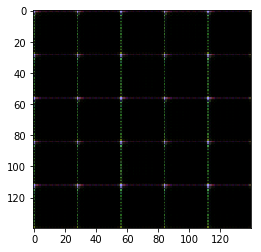

Epoch 1/1... Discriminator Loss: 1.4602... Generator Loss: 0.5762
Epoch 1/1... Discriminator Loss: 1.3062... Generator Loss: 1.1447
Epoch 1/1... Discriminator Loss: 1.3005... Generator Loss: 1.9906
Epoch 1/1... Discriminator Loss: 1.4789... Generator Loss: 0.6977
Epoch 1/1... Discriminator Loss: 1.5798... Generator Loss: 0.6527
Epoch 1/1... Discriminator Loss: 1.8496... Generator Loss: 0.4005
Epoch 1/1... Discriminator Loss: 1.6542... Generator Loss: 0.8474
Epoch 1/1... Discriminator Loss: 1.6655... Generator Loss: 1.9464
Epoch 1/1... Discriminator Loss: 1.4024... Generator Loss: 0.8166
Epoch 1/1... Discriminator Loss: 1.5084... Generator Loss: 0.6654


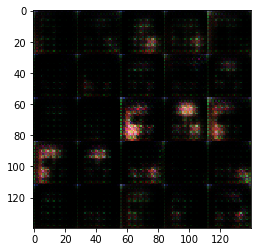

Epoch 1/1... Discriminator Loss: 1.6211... Generator Loss: 0.5116
Epoch 1/1... Discriminator Loss: 1.8672... Generator Loss: 0.3806
Epoch 1/1... Discriminator Loss: 1.1983... Generator Loss: 1.0942
Epoch 1/1... Discriminator Loss: 1.2631... Generator Loss: 0.6865
Epoch 1/1... Discriminator Loss: 1.3360... Generator Loss: 1.4061
Epoch 1/1... Discriminator Loss: 1.6216... Generator Loss: 1.4332
Epoch 1/1... Discriminator Loss: 1.4259... Generator Loss: 1.1409
Epoch 1/1... Discriminator Loss: 1.5536... Generator Loss: 1.2245
Epoch 1/1... Discriminator Loss: 1.2686... Generator Loss: 1.1066
Epoch 1/1... Discriminator Loss: 1.8579... Generator Loss: 0.4211


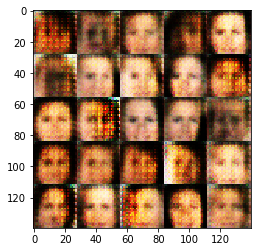

Epoch 1/1... Discriminator Loss: 1.2297... Generator Loss: 0.7319
Epoch 1/1... Discriminator Loss: 1.2551... Generator Loss: 0.7596
Epoch 1/1... Discriminator Loss: 1.4420... Generator Loss: 0.5374
Epoch 1/1... Discriminator Loss: 1.7618... Generator Loss: 0.4159
Epoch 1/1... Discriminator Loss: 1.1803... Generator Loss: 0.9826
Epoch 1/1... Discriminator Loss: 1.5048... Generator Loss: 0.4868
Epoch 1/1... Discriminator Loss: 1.5060... Generator Loss: 0.8541
Epoch 1/1... Discriminator Loss: 1.4836... Generator Loss: 0.5869
Epoch 1/1... Discriminator Loss: 1.4053... Generator Loss: 0.6582
Epoch 1/1... Discriminator Loss: 1.7240... Generator Loss: 0.4195


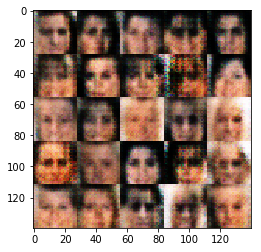

Epoch 1/1... Discriminator Loss: 1.3889... Generator Loss: 1.0489
Epoch 1/1... Discriminator Loss: 1.2440... Generator Loss: 0.9170
Epoch 1/1... Discriminator Loss: 1.3843... Generator Loss: 1.0146
Epoch 1/1... Discriminator Loss: 1.4487... Generator Loss: 0.5542
Epoch 1/1... Discriminator Loss: 1.6111... Generator Loss: 0.4954
Epoch 1/1... Discriminator Loss: 1.7947... Generator Loss: 1.5543
Epoch 1/1... Discriminator Loss: 1.6456... Generator Loss: 0.4525
Epoch 1/1... Discriminator Loss: 1.4858... Generator Loss: 0.4434
Epoch 1/1... Discriminator Loss: 1.5317... Generator Loss: 0.7127
Epoch 1/1... Discriminator Loss: 1.4564... Generator Loss: 0.9611


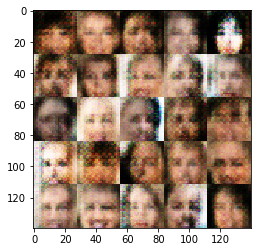

Epoch 1/1... Discriminator Loss: 1.5292... Generator Loss: 1.2018
Epoch 1/1... Discriminator Loss: 1.4233... Generator Loss: 0.7513
Epoch 1/1... Discriminator Loss: 1.3488... Generator Loss: 0.6423
Epoch 1/1... Discriminator Loss: 1.5530... Generator Loss: 0.4361
Epoch 1/1... Discriminator Loss: 1.5252... Generator Loss: 1.3518
Epoch 1/1... Discriminator Loss: 1.4142... Generator Loss: 0.9891
Epoch 1/1... Discriminator Loss: 1.6027... Generator Loss: 1.2393
Epoch 1/1... Discriminator Loss: 1.8175... Generator Loss: 1.6940
Epoch 1/1... Discriminator Loss: 1.2048... Generator Loss: 0.7644
Epoch 1/1... Discriminator Loss: 1.3955... Generator Loss: 0.7343


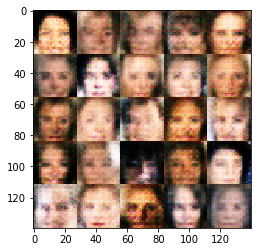

Epoch 1/1... Discriminator Loss: 1.3759... Generator Loss: 1.1256
Epoch 1/1... Discriminator Loss: 1.4810... Generator Loss: 1.2166
Epoch 1/1... Discriminator Loss: 1.5080... Generator Loss: 0.5917
Epoch 1/1... Discriminator Loss: 1.6610... Generator Loss: 0.4616
Epoch 1/1... Discriminator Loss: 1.4461... Generator Loss: 0.9853
Epoch 1/1... Discriminator Loss: 1.5097... Generator Loss: 0.4509
Epoch 1/1... Discriminator Loss: 1.4446... Generator Loss: 0.6700
Epoch 1/1... Discriminator Loss: 1.4000... Generator Loss: 1.0658
Epoch 1/1... Discriminator Loss: 1.0398... Generator Loss: 1.4201
Epoch 1/1... Discriminator Loss: 1.2648... Generator Loss: 1.0502


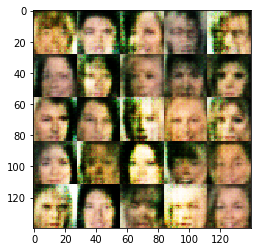

Epoch 1/1... Discriminator Loss: 1.3763... Generator Loss: 0.5923
Epoch 1/1... Discriminator Loss: 1.4748... Generator Loss: 0.9579
Epoch 1/1... Discriminator Loss: 1.1986... Generator Loss: 1.2456
Epoch 1/1... Discriminator Loss: 1.3159... Generator Loss: 0.9272
Epoch 1/1... Discriminator Loss: 1.5596... Generator Loss: 0.6869
Epoch 1/1... Discriminator Loss: 1.3353... Generator Loss: 0.9600
Epoch 1/1... Discriminator Loss: 1.4496... Generator Loss: 0.7143
Epoch 1/1... Discriminator Loss: 1.0239... Generator Loss: 1.3791
Epoch 1/1... Discriminator Loss: 1.6409... Generator Loss: 1.7145
Epoch 1/1... Discriminator Loss: 1.3411... Generator Loss: 0.8525


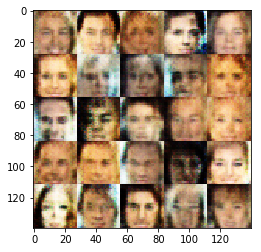

Epoch 1/1... Discriminator Loss: 1.3421... Generator Loss: 1.1206
Epoch 1/1... Discriminator Loss: 1.3523... Generator Loss: 0.5893
Epoch 1/1... Discriminator Loss: 1.4516... Generator Loss: 2.0252
Epoch 1/1... Discriminator Loss: 0.6855... Generator Loss: 1.5428
Epoch 1/1... Discriminator Loss: 1.6458... Generator Loss: 0.4305
Epoch 1/1... Discriminator Loss: 1.6115... Generator Loss: 0.6731
Epoch 1/1... Discriminator Loss: 1.3015... Generator Loss: 1.1582
Epoch 1/1... Discriminator Loss: 1.2677... Generator Loss: 0.7980
Epoch 1/1... Discriminator Loss: 1.4816... Generator Loss: 1.2401
Epoch 1/1... Discriminator Loss: 1.7087... Generator Loss: 0.3325


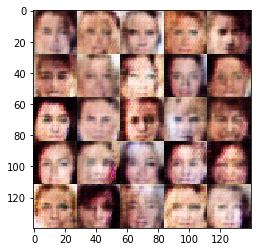

Epoch 1/1... Discriminator Loss: 1.4139... Generator Loss: 0.7818
Epoch 1/1... Discriminator Loss: 1.0736... Generator Loss: 0.8357
Epoch 1/1... Discriminator Loss: 1.2207... Generator Loss: 1.7955
Epoch 1/1... Discriminator Loss: 0.9789... Generator Loss: 0.8878
Epoch 1/1... Discriminator Loss: 0.9185... Generator Loss: 1.9444
Epoch 1/1... Discriminator Loss: 0.8755... Generator Loss: 1.0183
Epoch 1/1... Discriminator Loss: 1.2303... Generator Loss: 1.4768
Epoch 1/1... Discriminator Loss: 1.1361... Generator Loss: 0.8360
Epoch 1/1... Discriminator Loss: 0.6558... Generator Loss: 1.7089
Epoch 1/1... Discriminator Loss: 1.4982... Generator Loss: 0.6856


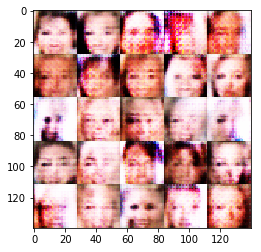

Epoch 1/1... Discriminator Loss: 1.2624... Generator Loss: 0.6867
Epoch 1/1... Discriminator Loss: 1.2227... Generator Loss: 1.4652
Epoch 1/1... Discriminator Loss: 1.1014... Generator Loss: 1.0579
Epoch 1/1... Discriminator Loss: 1.2927... Generator Loss: 0.8830
Epoch 1/1... Discriminator Loss: 1.2133... Generator Loss: 1.1776
Epoch 1/1... Discriminator Loss: 1.0935... Generator Loss: 1.0274
Epoch 1/1... Discriminator Loss: 1.1617... Generator Loss: 1.0202
Epoch 1/1... Discriminator Loss: 1.1727... Generator Loss: 0.9063
Epoch 1/1... Discriminator Loss: 1.0016... Generator Loss: 1.4491
Epoch 1/1... Discriminator Loss: 1.5469... Generator Loss: 1.7062


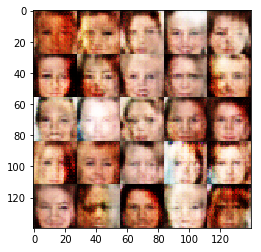

Epoch 1/1... Discriminator Loss: 1.1494... Generator Loss: 0.6508
Epoch 1/1... Discriminator Loss: 1.1772... Generator Loss: 1.5151
Epoch 1/1... Discriminator Loss: 1.3239... Generator Loss: 1.5874
Epoch 1/1... Discriminator Loss: 1.5337... Generator Loss: 1.5727
Epoch 1/1... Discriminator Loss: 1.3404... Generator Loss: 1.4336
Epoch 1/1... Discriminator Loss: 1.0238... Generator Loss: 0.7681
Epoch 1/1... Discriminator Loss: 1.2876... Generator Loss: 0.6914
Epoch 1/1... Discriminator Loss: 1.1323... Generator Loss: 0.6782
Epoch 1/1... Discriminator Loss: 1.0856... Generator Loss: 1.5905
Epoch 1/1... Discriminator Loss: 1.7420... Generator Loss: 0.3538


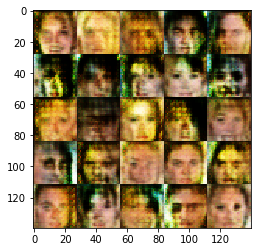

Epoch 1/1... Discriminator Loss: 1.4906... Generator Loss: 0.9367
Epoch 1/1... Discriminator Loss: 1.1568... Generator Loss: 1.1402
Epoch 1/1... Discriminator Loss: 1.2054... Generator Loss: 1.1306
Epoch 1/1... Discriminator Loss: 1.4162... Generator Loss: 1.0756
Epoch 1/1... Discriminator Loss: 1.2361... Generator Loss: 0.7214
Epoch 1/1... Discriminator Loss: 1.2638... Generator Loss: 1.0334
Epoch 1/1... Discriminator Loss: 1.2798... Generator Loss: 0.6609
Epoch 1/1... Discriminator Loss: 1.2514... Generator Loss: 0.9448
Epoch 1/1... Discriminator Loss: 1.2918... Generator Loss: 1.0939
Epoch 1/1... Discriminator Loss: 1.0707... Generator Loss: 0.8509


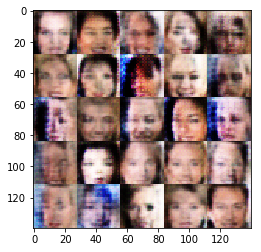

Epoch 1/1... Discriminator Loss: 1.7294... Generator Loss: 1.5734
Epoch 1/1... Discriminator Loss: 1.0195... Generator Loss: 0.9948
Epoch 1/1... Discriminator Loss: 1.0907... Generator Loss: 0.8837
Epoch 1/1... Discriminator Loss: 1.1708... Generator Loss: 0.9114
Epoch 1/1... Discriminator Loss: 1.1986... Generator Loss: 1.0662
Epoch 1/1... Discriminator Loss: 1.0665... Generator Loss: 0.9296
Epoch 1/1... Discriminator Loss: 1.3987... Generator Loss: 1.2871
Epoch 1/1... Discriminator Loss: 1.2389... Generator Loss: 0.6922
Epoch 1/1... Discriminator Loss: 1.3828... Generator Loss: 0.6653
Epoch 1/1... Discriminator Loss: 1.1043... Generator Loss: 0.9263


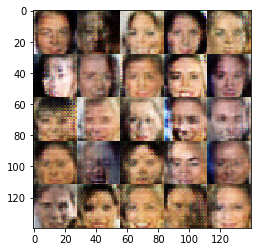

Epoch 1/1... Discriminator Loss: 2.0706... Generator Loss: 0.2742
Epoch 1/1... Discriminator Loss: 1.3322... Generator Loss: 0.7491
Epoch 1/1... Discriminator Loss: 1.3348... Generator Loss: 0.5481
Epoch 1/1... Discriminator Loss: 1.1654... Generator Loss: 0.8705
Epoch 1/1... Discriminator Loss: 1.3107... Generator Loss: 0.7011
Epoch 1/1... Discriminator Loss: 1.2656... Generator Loss: 1.0691
Epoch 1/1... Discriminator Loss: 1.6472... Generator Loss: 0.3986
Epoch 1/1... Discriminator Loss: 1.4802... Generator Loss: 1.1794
Epoch 1/1... Discriminator Loss: 1.3065... Generator Loss: 0.7045
Epoch 1/1... Discriminator Loss: 1.3006... Generator Loss: 1.2461


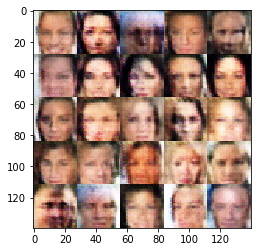

Epoch 1/1... Discriminator Loss: 1.1556... Generator Loss: 0.8749
Epoch 1/1... Discriminator Loss: 1.3646... Generator Loss: 1.3206
Epoch 1/1... Discriminator Loss: 1.2556... Generator Loss: 0.7085
Epoch 1/1... Discriminator Loss: 1.4735... Generator Loss: 0.4935
Epoch 1/1... Discriminator Loss: 1.1956... Generator Loss: 0.9110
Epoch 1/1... Discriminator Loss: 1.3948... Generator Loss: 0.7679
Epoch 1/1... Discriminator Loss: 1.1671... Generator Loss: 0.7716
Epoch 1/1... Discriminator Loss: 1.2697... Generator Loss: 0.9432
Epoch 1/1... Discriminator Loss: 1.3677... Generator Loss: 0.7873
Epoch 1/1... Discriminator Loss: 1.3428... Generator Loss: 0.7087


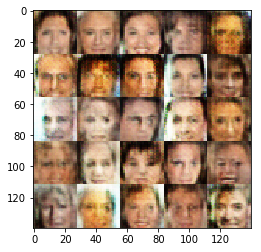

Epoch 1/1... Discriminator Loss: 1.3723... Generator Loss: 1.0018
Epoch 1/1... Discriminator Loss: 1.3181... Generator Loss: 0.5707
Epoch 1/1... Discriminator Loss: 1.1492... Generator Loss: 0.7561
Epoch 1/1... Discriminator Loss: 1.3722... Generator Loss: 0.6961
Epoch 1/1... Discriminator Loss: 1.3443... Generator Loss: 0.8070
Epoch 1/1... Discriminator Loss: 1.3828... Generator Loss: 0.6531
Epoch 1/1... Discriminator Loss: 1.3781... Generator Loss: 0.9924
Epoch 1/1... Discriminator Loss: 1.1549... Generator Loss: 0.7082
Epoch 1/1... Discriminator Loss: 1.1541... Generator Loss: 1.0478
Epoch 1/1... Discriminator Loss: 1.9582... Generator Loss: 1.7246


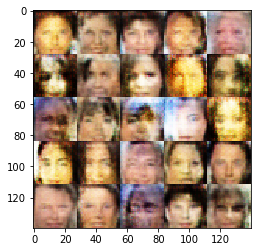

Epoch 1/1... Discriminator Loss: 0.9509... Generator Loss: 1.3396
Epoch 1/1... Discriminator Loss: 1.2728... Generator Loss: 1.2351
Epoch 1/1... Discriminator Loss: 1.2407... Generator Loss: 1.1527
Epoch 1/1... Discriminator Loss: 1.3912... Generator Loss: 1.1620
Epoch 1/1... Discriminator Loss: 1.2485... Generator Loss: 0.7502
Epoch 1/1... Discriminator Loss: 1.2595... Generator Loss: 0.5685
Epoch 1/1... Discriminator Loss: 1.2750... Generator Loss: 0.6990
Epoch 1/1... Discriminator Loss: 1.2532... Generator Loss: 0.9133
Epoch 1/1... Discriminator Loss: 1.0587... Generator Loss: 0.9518
Epoch 1/1... Discriminator Loss: 1.5383... Generator Loss: 0.5730


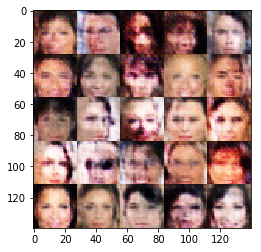

Epoch 1/1... Discriminator Loss: 0.6788... Generator Loss: 1.5184
Epoch 1/1... Discriminator Loss: 1.2150... Generator Loss: 0.7593
Epoch 1/1... Discriminator Loss: 1.5154... Generator Loss: 1.3756
Epoch 1/1... Discriminator Loss: 1.1003... Generator Loss: 1.0910
Epoch 1/1... Discriminator Loss: 1.2636... Generator Loss: 0.7710
Epoch 1/1... Discriminator Loss: 2.4711... Generator Loss: 3.5171
Epoch 1/1... Discriminator Loss: 1.0791... Generator Loss: 0.9019
Epoch 1/1... Discriminator Loss: 1.2595... Generator Loss: 0.8955
Epoch 1/1... Discriminator Loss: 1.2841... Generator Loss: 0.7344
Epoch 1/1... Discriminator Loss: 1.1126... Generator Loss: 0.7466


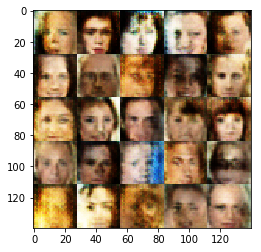

Epoch 1/1... Discriminator Loss: 1.4438... Generator Loss: 1.0401
Epoch 1/1... Discriminator Loss: 1.3327... Generator Loss: 0.8000
Epoch 1/1... Discriminator Loss: 1.3049... Generator Loss: 0.5646
Epoch 1/1... Discriminator Loss: 1.0587... Generator Loss: 1.0456
Epoch 1/1... Discriminator Loss: 1.1909... Generator Loss: 0.9093
Epoch 1/1... Discriminator Loss: 1.3271... Generator Loss: 0.5868
Epoch 1/1... Discriminator Loss: 1.0965... Generator Loss: 1.0450
Epoch 1/1... Discriminator Loss: 0.9713... Generator Loss: 0.9724
Epoch 1/1... Discriminator Loss: 0.8720... Generator Loss: 0.9980
Epoch 1/1... Discriminator Loss: 1.1386... Generator Loss: 1.3931


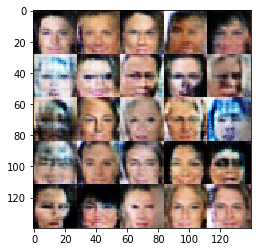

Epoch 1/1... Discriminator Loss: 1.0539... Generator Loss: 1.1781
Epoch 1/1... Discriminator Loss: 1.4492... Generator Loss: 1.4163
Epoch 1/1... Discriminator Loss: 1.3270... Generator Loss: 1.1361
Epoch 1/1... Discriminator Loss: 1.0510... Generator Loss: 0.8427
Epoch 1/1... Discriminator Loss: 1.3228... Generator Loss: 0.5614
Epoch 1/1... Discriminator Loss: 1.2341... Generator Loss: 1.0039
Epoch 1/1... Discriminator Loss: 1.2207... Generator Loss: 0.8185
Epoch 1/1... Discriminator Loss: 1.0792... Generator Loss: 1.0870
Epoch 1/1... Discriminator Loss: 1.3563... Generator Loss: 1.1094
Epoch 1/1... Discriminator Loss: 1.0556... Generator Loss: 1.1376


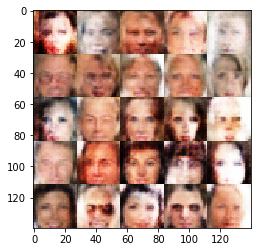

Epoch 1/1... Discriminator Loss: 1.2508... Generator Loss: 1.0496
Epoch 1/1... Discriminator Loss: 1.2141... Generator Loss: 0.6753
Epoch 1/1... Discriminator Loss: 1.2196... Generator Loss: 0.8809
Epoch 1/1... Discriminator Loss: 1.1134... Generator Loss: 0.8117
Epoch 1/1... Discriminator Loss: 1.2807... Generator Loss: 0.8621
Epoch 1/1... Discriminator Loss: 1.1800... Generator Loss: 0.9023
Epoch 1/1... Discriminator Loss: 1.1024... Generator Loss: 0.9654
Epoch 1/1... Discriminator Loss: 1.1587... Generator Loss: 1.0789
Epoch 1/1... Discriminator Loss: 1.3573... Generator Loss: 1.6014
Epoch 1/1... Discriminator Loss: 1.9226... Generator Loss: 1.3737


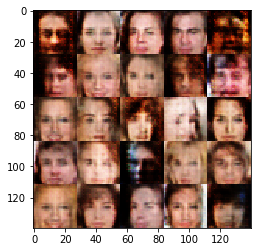

Epoch 1/1... Discriminator Loss: 1.2451... Generator Loss: 1.0776
Epoch 1/1... Discriminator Loss: 1.1062... Generator Loss: 1.1888
Epoch 1/1... Discriminator Loss: 1.1627... Generator Loss: 1.0039
Epoch 1/1... Discriminator Loss: 1.2232... Generator Loss: 0.9176
Epoch 1/1... Discriminator Loss: 1.3007... Generator Loss: 0.5684
Epoch 1/1... Discriminator Loss: 1.4080... Generator Loss: 1.0083
Epoch 1/1... Discriminator Loss: 1.3333... Generator Loss: 1.0334
Epoch 1/1... Discriminator Loss: 1.1367... Generator Loss: 0.6765
Epoch 1/1... Discriminator Loss: 1.1342... Generator Loss: 0.9395
Epoch 1/1... Discriminator Loss: 1.2268... Generator Loss: 1.3788


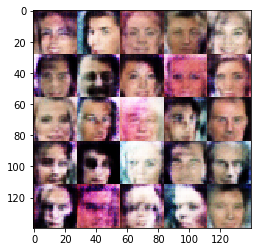

Epoch 1/1... Discriminator Loss: 0.9449... Generator Loss: 1.1072
Epoch 1/1... Discriminator Loss: 1.3955... Generator Loss: 1.2157
Epoch 1/1... Discriminator Loss: 1.2030... Generator Loss: 0.8599
Epoch 1/1... Discriminator Loss: 1.3305... Generator Loss: 0.8851
Epoch 1/1... Discriminator Loss: 1.2726... Generator Loss: 0.8273
Epoch 1/1... Discriminator Loss: 0.9285... Generator Loss: 1.3648
Epoch 1/1... Discriminator Loss: 1.3753... Generator Loss: 0.6530
Epoch 1/1... Discriminator Loss: 1.1803... Generator Loss: 0.8414
Epoch 1/1... Discriminator Loss: 1.2799... Generator Loss: 0.8159
Epoch 1/1... Discriminator Loss: 1.2763... Generator Loss: 1.1393


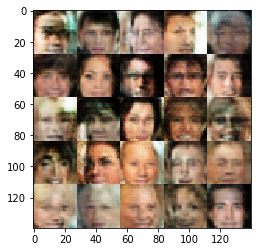

Epoch 1/1... Discriminator Loss: 1.1778... Generator Loss: 0.9018
Epoch 1/1... Discriminator Loss: 1.2002... Generator Loss: 1.0533
Epoch 1/1... Discriminator Loss: 1.2103... Generator Loss: 1.0476
Epoch 1/1... Discriminator Loss: 1.2786... Generator Loss: 1.1140
Epoch 1/1... Discriminator Loss: 1.2468... Generator Loss: 0.6964
Epoch 1/1... Discriminator Loss: 1.0307... Generator Loss: 0.7713
Epoch 1/1... Discriminator Loss: 1.1873... Generator Loss: 0.8256
Epoch 1/1... Discriminator Loss: 1.2358... Generator Loss: 0.8076
Epoch 1/1... Discriminator Loss: 1.3841... Generator Loss: 0.9411
Epoch 1/1... Discriminator Loss: 1.5317... Generator Loss: 0.6081


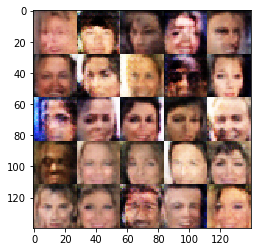

Epoch 1/1... Discriminator Loss: 1.0320... Generator Loss: 0.7899
Epoch 1/1... Discriminator Loss: 1.2654... Generator Loss: 0.8492
Epoch 1/1... Discriminator Loss: 1.2410... Generator Loss: 0.8738
Epoch 1/1... Discriminator Loss: 1.2832... Generator Loss: 0.6388
Epoch 1/1... Discriminator Loss: 1.3935... Generator Loss: 0.7532
Epoch 1/1... Discriminator Loss: 1.5984... Generator Loss: 0.4584
Epoch 1/1... Discriminator Loss: 1.3733... Generator Loss: 0.8676
Epoch 1/1... Discriminator Loss: 1.2354... Generator Loss: 0.7242
Epoch 1/1... Discriminator Loss: 1.1168... Generator Loss: 0.7782
Epoch 1/1... Discriminator Loss: 1.2080... Generator Loss: 0.8867


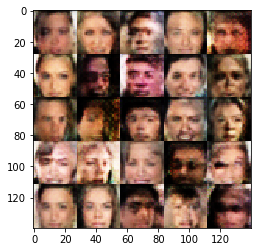

Epoch 1/1... Discriminator Loss: 1.1533... Generator Loss: 0.7453
Epoch 1/1... Discriminator Loss: 1.1258... Generator Loss: 0.8090
Epoch 1/1... Discriminator Loss: 1.2061... Generator Loss: 0.6875
Epoch 1/1... Discriminator Loss: 1.1585... Generator Loss: 0.7141
Epoch 1/1... Discriminator Loss: 1.2357... Generator Loss: 0.7904
Epoch 1/1... Discriminator Loss: 1.0856... Generator Loss: 0.9351
Epoch 1/1... Discriminator Loss: 1.4329... Generator Loss: 0.8257
Epoch 1/1... Discriminator Loss: 1.2440... Generator Loss: 1.3148
Epoch 1/1... Discriminator Loss: 1.1257... Generator Loss: 1.0348
Epoch 1/1... Discriminator Loss: 1.3122... Generator Loss: 0.7999


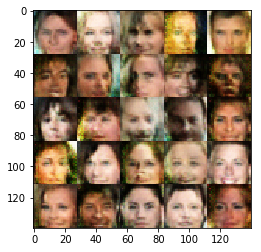

Epoch 1/1... Discriminator Loss: 1.1673... Generator Loss: 1.0419
Epoch 1/1... Discriminator Loss: 1.0239... Generator Loss: 1.0276
Epoch 1/1... Discriminator Loss: 1.2382... Generator Loss: 0.7296
Epoch 1/1... Discriminator Loss: 1.2233... Generator Loss: 0.9028
Epoch 1/1... Discriminator Loss: 1.3006... Generator Loss: 0.5508
Epoch 1/1... Discriminator Loss: 1.4159... Generator Loss: 0.7453
Epoch 1/1... Discriminator Loss: 1.2922... Generator Loss: 0.9511
Epoch 1/1... Discriminator Loss: 0.9845... Generator Loss: 0.9509
Epoch 1/1... Discriminator Loss: 1.4138... Generator Loss: 0.5184
Epoch 1/1... Discriminator Loss: 1.2166... Generator Loss: 0.9299


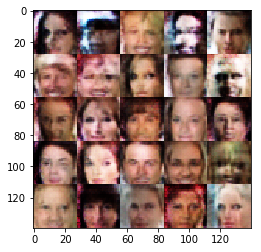

Epoch 1/1... Discriminator Loss: 1.3104... Generator Loss: 1.1273
Epoch 1/1... Discriminator Loss: 1.3151... Generator Loss: 1.1627
Epoch 1/1... Discriminator Loss: 1.3303... Generator Loss: 0.9535
Epoch 1/1... Discriminator Loss: 1.1611... Generator Loss: 0.9061
Epoch 1/1... Discriminator Loss: 1.3080... Generator Loss: 0.9858
Epoch 1/1... Discriminator Loss: 1.1621... Generator Loss: 0.8845
Epoch 1/1... Discriminator Loss: 1.1324... Generator Loss: 1.3830
Epoch 1/1... Discriminator Loss: 0.5280... Generator Loss: 2.3553
Epoch 1/1... Discriminator Loss: 1.2423... Generator Loss: 0.7912
Epoch 1/1... Discriminator Loss: 1.2124... Generator Loss: 0.8431


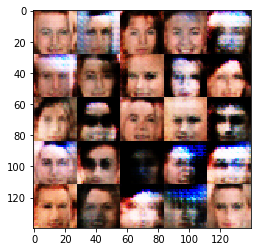

Epoch 1/1... Discriminator Loss: 0.9475... Generator Loss: 0.9852
Epoch 1/1... Discriminator Loss: 1.3869... Generator Loss: 0.6279
Epoch 1/1... Discriminator Loss: 1.4606... Generator Loss: 1.1494
Epoch 1/1... Discriminator Loss: 1.0492... Generator Loss: 1.4739
Epoch 1/1... Discriminator Loss: 1.2761... Generator Loss: 0.6471
Epoch 1/1... Discriminator Loss: 1.3659... Generator Loss: 1.3487
Epoch 1/1... Discriminator Loss: 1.1056... Generator Loss: 1.7319
Epoch 1/1... Discriminator Loss: 1.3360... Generator Loss: 0.5647
Epoch 1/1... Discriminator Loss: 1.0209... Generator Loss: 0.9123
Epoch 1/1... Discriminator Loss: 0.9442... Generator Loss: 0.9949


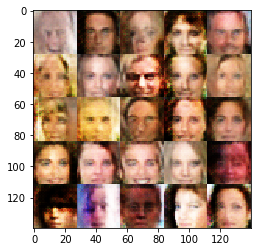

Epoch 1/1... Discriminator Loss: 1.2540... Generator Loss: 0.6420
Epoch 1/1... Discriminator Loss: 1.1920... Generator Loss: 1.0043
Epoch 1/1... Discriminator Loss: 0.9281... Generator Loss: 1.0693
Epoch 1/1... Discriminator Loss: 1.2879... Generator Loss: 0.9136
Epoch 1/1... Discriminator Loss: 0.9604... Generator Loss: 1.0278
Epoch 1/1... Discriminator Loss: 1.4812... Generator Loss: 0.8798
Epoch 1/1... Discriminator Loss: 3.5990... Generator Loss: 0.1169
Epoch 1/1... Discriminator Loss: 0.9556... Generator Loss: 1.3615
Epoch 1/1... Discriminator Loss: 1.2027... Generator Loss: 1.0933
Epoch 1/1... Discriminator Loss: 1.1462... Generator Loss: 0.8781


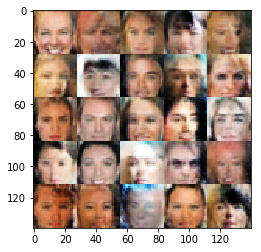

Epoch 1/1... Discriminator Loss: 1.1177... Generator Loss: 0.7647
Epoch 1/1... Discriminator Loss: 1.0053... Generator Loss: 1.0611
Epoch 1/1... Discriminator Loss: 1.4208... Generator Loss: 1.0881
Epoch 1/1... Discriminator Loss: 1.6789... Generator Loss: 0.3610
Epoch 1/1... Discriminator Loss: 1.5134... Generator Loss: 0.4709
Epoch 1/1... Discriminator Loss: 1.2906... Generator Loss: 0.7068


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.